# Consistency Assessment of Satellite Sea Surface Temperature for Climate Monitoring

Production date: 16-05-2025

Produced by: CNR-ISMAR

## 🌍 Use case: Monitoring climate variability using satellite-derived SST

## ❓ Quality assessment question(s)
* **Do these datasets provide consistent representations of SST climatology and its variability?**

We aim here to evaluate the consistency and representativeness of sea surface temperature (SST) climatology and its variability in satellite-based long-term climate data records (CDRs). 
To this end, two different SST CDRs have been intercompared on a 30-year long (1982-2011) period. 
The full period of common coverage (1982-2016) was used when extracting time series, to have more information on each dataset's capability to properly represent large scale climatic oscillations, such as the El-Nino Southern Oscillation (ENSO).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Both datasets provide consistent results, well reproducing SST mean values and the main patterns of SST variability on a variety of scales, ranging from seasonal to (multi-)annual time scales;
* Both datasets can be exploited for climate studies. As an example, El-Niño/La-Niña events are well characterized by both GMPE and ESA CCI SST products
;
* ESA CCI SST dataset should be used with caution in the first decade of the CDR. Significant discrepancies with respect to the ensemble mean GMPE dataset were indeed observed in the 1982-1992 period;
```

```{figure} attachment:bb2e502f-9d8a-4404-8c19-418886e6e483.png
---
height: 400px
width: 550px
---
*Nino 3.4 Time series calculated according to [[5]](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)*
```
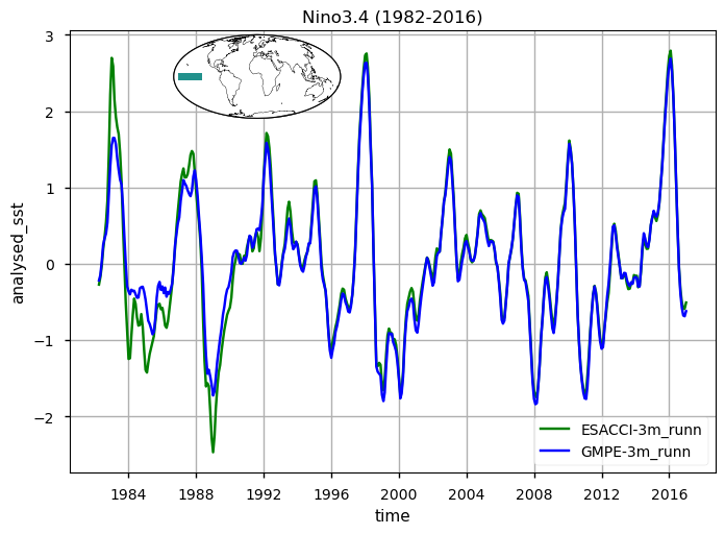

## 📋 Methodology

We intercompare the performances of the European Space Agency Climate Change Initiative (ESA CCI) SST dataset v2.1 and the GHRSST multi product ensemble (GMPE) SST.

Respectively, catalogue entries available from the CDS are the following:
* Sea surface temperature daily gridded data from 1981 to 2016 derived from a multi-product satellite-based ensemble - from the Group for High Resolution Sea Surface Temperature (GHRSST) multi-product ensemble (GMPE) produced by the European Space Agency SST Climate Change Initiative (ESA CCI SST) (GMPE in the following). The GMPE SST is obtained as the ensemble median of 16 global contributing Level-4 (L4) analyses (including the ESA CCI v2.0 and v1.1) [[1]](https://doi.org/10.1016/j.rse.2018.12.015);
* Sea Surface Temperature daily data from 1981 to present derived from satellite observations, ESA CCI SST L4 dataset v2.1 (ESA CCI SST in the following). This L4 datasets provides daily global SST fields from the merging  of space born Infrared SSTs through a variational assimilation algorithm [[2]](https://doi.org/10.1038/s41597-019-0236-x);

The methodology employed is suitable for investigating the representation of SST variability over climatological time scales. 

-The climatology has been defined over a common, standard 30-year long period 1982-2011. 

-Annual and seasonal mean, as well as standard deviation, have been computed over the time axis. 

-Time series of globally averaged SST anomalies were derived by subtracting the annual cycle from the product’s monthly mean time series, representing the mean of each month over the entire period (1982-2016). 

This processing aims to minimize the impact of the seasonal component, thereby enhancing the contribution of higher and lower frequency components. 

The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](section-1)**

**[](section-2)**

Functions for rechunking to optimize caching of intermediate results, get nan values on land and convert to degree celsius in the ocean are defined in this section. Note that chunking is employed to handle more efficiently the large data volume.
Notice that while in GMPE SST sea-ice covered points have nan values, this is not the case in ESA CCI SST, which has an additional variable called "mask". We use this ancillary information to mask out sea-ice covered regions (the variable mask is valued-1 for ocean only points).

**[](section-3)**

Tuples and dictionaries containing infomations such as reduction operations (mean and standard deviation) are defined in this section, and the request is set up, transforming the data while downloading them, according to the proposed diagnostics.

**[](section-4)**
 * 4.1 Plot Annual Maps
 * 4.2 Plot Bias maps
 * 4.3 Plot Seasonal Maps
 * 4.4 Plot of global monthly mean time series, Eastern Tropical Pacific SST (El Niño 3), and East Central Tropical Pacific SST (El Niño 3.4)


## 📈 Analysis and results 
(section-1)=
### 1. Import packages and define parameters for the requests to the CDS

In the following cell the necessary packages are imported, defining the request to the CDS to download ESA CCI and GMPE SST from 1982 to 2011. Regions to calculate nino3 and nino3.4, and global timeseries are defined.

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import warnings
import numpy as np
warnings.simplefilter("ignore")

plt.style.use("seaborn-v0_8-notebook")

# Time
year_start = 1982
year_stop_map = 2011
year_stop_timeseries = 2016 

# Regions
regions = {
    "nino3.4": {"lon_slice": slice(-170, -120), "lat_slice": slice(-5, 5)},
    "nino3": {"lon_slice": slice(-150, -90), "lat_slice": slice(-5, 5)},
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 90)},
}

# Requests
request_dicts = {
    "ESACCI": {
        "collection_id": "satellite-sea-surface-temperature",
        "request": {
            "processinglevel": "level_4",
            "format": "zip",
            "variable": "all",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
        },
        "chunks": {"year": 1, "month": 1},
    },
    "GMPE": {
        "collection_id": "satellite-sea-surface-temperature-ensemble-product",
        "request": {
            "format": "zip",
            "variable": "all",
        },
        "chunks": {"year": 1, "month": 1, "day": 12},  # CDS limit is 12
    },
}

# Parameters to speed up I/O. For more information, see https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html
open_mfdataset_kwargs = {
    "concat_dim": "time", #Concatenation of multiple files along the temporal dimension
    "combine": "nested", #the argument "nested" assures to have no conflicts when one variable exist only in one dataset
    "data_vars": "minimal", #if multiple files of the same dataset contain a different number of variables, keep only the ones common to all files.
    "coords": "minimal", #same as above for coordinates
    "compat": "override", #String indicating how to compare variables of the same name for potential conflicts when merging. “override”: skip comparing and pick variable from first dataset
    "parallel": True, #Parallel opening and processing of the multiple-file dataset, to speed up.
}

(section-2)=
### 2. Define functions to cache

In [6]:
def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_time_reductions(ds, func, **kwargs):
    ds = rechunk(ds)
    da = get_masked_sst(ds)
    da_reduced = rechunk(func(da, **kwargs))
    if "season" in da_reduced.dims:
        da_reduced = da_reduced.sel(season=sorted(set(da["time"].dt.season.values)))
    return rechunk(da_reduced).to_dataset()


def compute_spatial_weighted_reductions(ds, reduction, lon_slice, lat_slice):
    ds = rechunk(ds)
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_masked_sst(ds)
    da = diagnostics.spatial_weighted_mean(da, weights=True).compute()
    grouped = da.groupby("time.dayofyear")
    func = getattr(grouped, reduction)
    da_reduced_doy = func("time", keep_attrs=True)
    da_reduced = (grouped - da_reduced_doy)
    return rechunk(da_reduced).to_dataset()


(section-3)=
### 3. Download and transform step

In [7]:
# Settings
reductions = ("mean", "std")
season_month_dict = {
    "DJF": {"12", "01", "02"},
    "MAM": {"03", "04", "05"},
    "JJA": {"06", "07", "08"},
    "SON": {"09", "10", "11"},
}
start = f"{year_start-1}-12"
stop = f"{year_stop_map}-11"

# Initialize variables
datasets_annual = {}
datasets_seasonal = {}
timeseries_ds_list = []
for product, request_dict in request_dicts.items():
    kwargs = {
        "collection_id": request_dict["collection_id"],
        "transform_chunks": False,
        "chunks": request_dict["chunks"],
        **open_mfdataset_kwargs,
    }

    # Annual
    print(f"{product=}")
    annual_ds_list = []
    for year in tqdm.tqdm(range(year_start, year_stop_map + 1), desc="annual"):
        # Note: year from December year-1 to November year
        annual_requests = download.update_request_date(
            request_dict["request"],
            start=f"{year-1}-12",
            stop=f"{year}-11",
            stringify_dates=True,
        )
        tmp_ds_list = []
        for reduction in reductions:
            func = getattr(diagnostics, f"time_weighted_{reduction}")
            ds = download.download_and_transform(
                **kwargs,
                requests=annual_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False, "skipna": False},
            )
            tmp_ds_list.append(rechunk(ds).expand_dims(reduction=[reduction]))
        annual_ds_list.append(
            xr.concat(tmp_ds_list, "reduction").expand_dims(year=[year])
        )
    datasets_annual[product] = xr.concat(annual_ds_list, "year")

    # Seasonal and spatial
    requests = download.update_request_date(
        request_dict["request"],
        start=f"{year_start}-01",
        stop=f"{year_stop_map}-12",
        stringify_dates=True,
    )
    
    requests_ts = download.update_request_date(
        request_dict["request"],
        start=f"{year_start}-01",
        stop=f"{year_stop_timeseries}-12",
        stringify_dates=True,
    )

    reduction="mean" 
    for region, slices in tqdm.tqdm(regions.items(), desc="spatial reduction"):
            ds = download.download_and_transform(
                **kwargs,
                requests=requests_ts,
                transform_func=compute_spatial_weighted_reductions,
                transform_func_kwargs={"reduction": reduction} | slices,
            )
            timeseries_ds_list.append(
                ds.expand_dims(
                    product=[product], reduction=[reduction], region=[region]
                )
            )
        
    seasonal_ds_list = []
    for reduction in reductions:
        # Seasonal
        func = getattr(diagnostics, f"seasonal_weighted_{reduction}")
        tmp_ds_list = []
        for season, months in tqdm.tqdm(season_month_dict.items(), desc="season"):
            season_requests = [
                {
                    k: v
                    if k != "month"
                    else sorted(set({v} if isinstance(v, str) else v) & months)
                    for k, v in r.items()
                }
                for r in requests
            ]
            ds = download.download_and_transform(
                **kwargs,
                requests=season_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False, "skipna": False},
            )
            tmp_ds_list.append(rechunk(ds))
        seasonal_ds_list.append(
            xr.concat(tmp_ds_list, "season").expand_dims(reduction=[reduction])
        )
    datasets_seasonal[product] = xr.concat(seasonal_ds_list, "reduction")

ds_timeseries = xr.merge(timeseries_ds_list)
del tmp_ds_list, annual_ds_list, seasonal_ds_list, timeseries_ds_list

product='ESACCI'


season: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


product='GMPE'


season: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


(section-4)=
### 4. Plot Annual Maps, Bias, Seasonal Maps and Timeseries, with discussions

In the following cells results of the diagnostics are shown and discussed.

In [8]:
datasets = []
for product, ds in datasets_annual.items():
    if product == "ESACCI":
        ds = ds.coarsen(latitude=5, longitude=5).mean()
        ds["latitude"] = ds["latitude"].round(3)
        ds["longitude"] = ds["longitude"].round(3)
    datasets.append(ds.expand_dims(product=[product]))
ds = xr.concat(datasets, "product")



ds_annual_low_res = ds.sel(reduction="mean")
datasets = []
for reduction in ("mean", "std"):
    ds = getattr(ds_annual_low_res, reduction)("year", keep_attrs=True, skipna=False)
    datasets.append(ds.expand_dims(reduction=[reduction]))
ds = xr.concat(datasets, "reduction")

#### 4.1 Plot Annual Maps

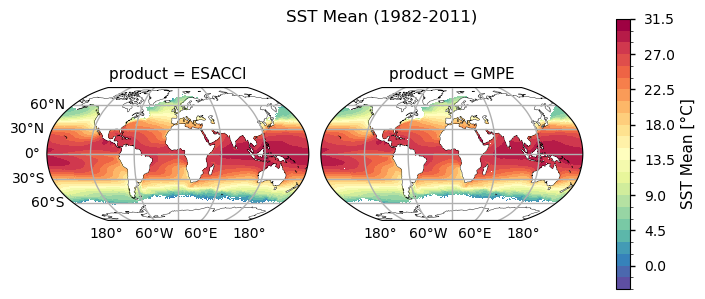

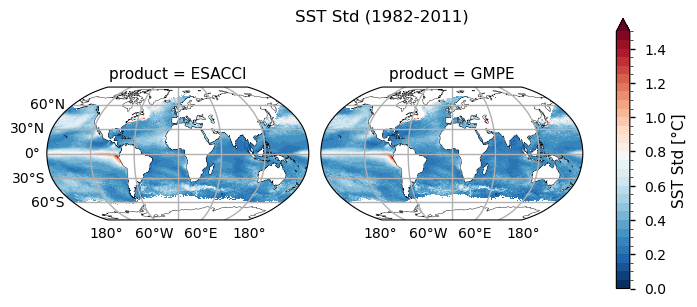

In [9]:
for reduction, da in ds["analysed_sst"].groupby("reduction"):
    title = f"SST {reduction.title()} ({year_start}-{year_stop_map})"
    kwargs = {"projection": ccrs.Robinson(), "cbar_kwargs": {'label':f"SST {reduction.title()} [{da.attrs['units']}]"}}

    # Reduction
    plot.projected_map(
        da.squeeze(),
        cmap="Spectral_r" if reduction == "mean" else "RdBu_r",
        center=False,
        levels=31,
        vmin=0.0 if reduction=="std" else None,
        vmax=1.5 if reduction=="std" else None,
        col="product",
        #row='year',
        **kwargs,
    )
    plt.suptitle(title)
    plt.show()
    

The global distribution of the mean SST during the complete 30 years from 1982 to 2011 is shown in the top panel. The climatology correctly reveals the dominant latitudinal spatial SST pattern: higher at the tropics, milder at middle latitudes and lower in the polar regions (see, e.g., [[3]](https://doi.org/10.1146/annurev-marine-120408-151453)). The globally averaged SST value is estimated in 20.11 $\pm$ 0.39 °C in ESA CCI and  20.23 $\pm$ 0.37 °C in GMPE.
The standard deviation map of annual mean SST is shown in the bottom panel. The annual average removes the seasonal variability and better quantifies the magnitude and spatial distribution of the nonseasonal SST variability. The standard deviation map evidences some patterns of the main current systems such as the Gulf Current and the Kuroshio Current, as well as regions such El-Nino in the tropical pacific, where the SST anomaly standard deviation exceeds 1.5°C. The main upwelling systems as, e.g., Perù-Chili, Benguela, NW-African coast and along the southern Saudi Arabia coast are also evident, as well as regions of strong mixing, like the Antarctic Circumpolar Current and the Agulhas Leakage.

#### 4.2 Plot Bias Maps

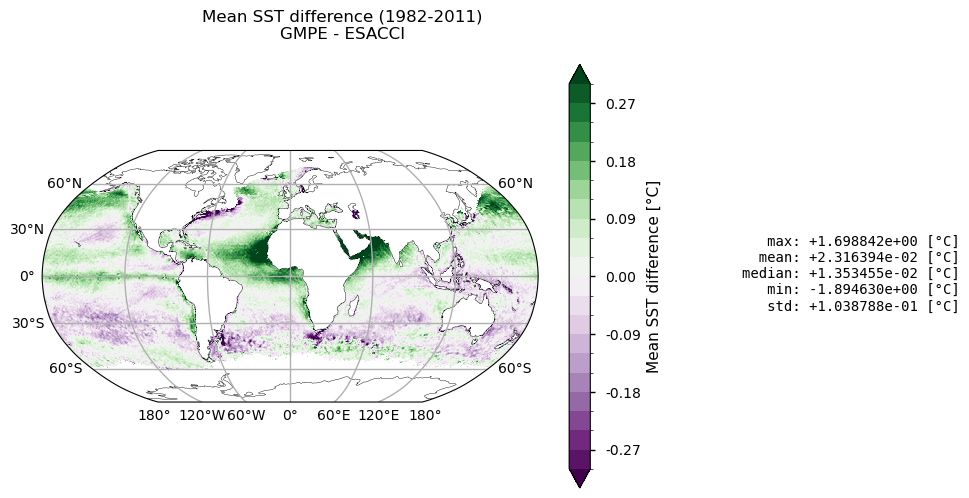

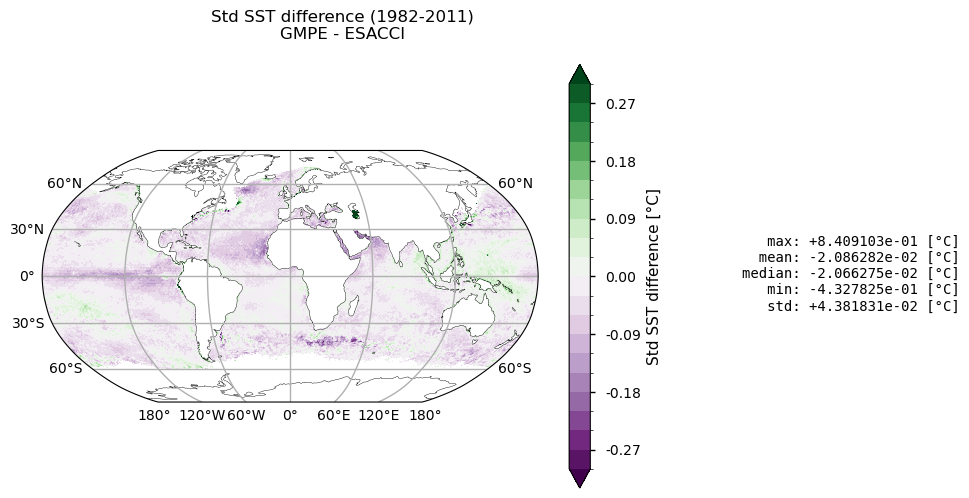

In [10]:
for reduction, da in ds["analysed_sst"].groupby("reduction"):
    # Bias
    with xr.set_options(keep_attrs=True):
        bias = da.diff("product").squeeze().chunk(dict(latitude=-1)).chunk(dict(longitude=-1)).squeeze()
        kwargs = {"projection": ccrs.Robinson(), "cbar_kwargs": {'label':f"{reduction.title()} SST difference [{da.attrs['units']}]", 'format': '%.2f'}}
    plot.projected_map(
        bias, cmap="PRGn", center=False, levels=21, vmin=-.3, vmax=.3, **kwargs
    )
    title = f"{reduction.title()} SST difference ({year_start}-{year_stop_map})"
    plt.title('')
    plt.suptitle(title + "\n" + " - ".join(da["product"][::-1].values))
    plt.show()

Top panel depicts the difference between climatologies in GMPE and ESA CCI SSTs. In general, positive (negative) values stand for GMPE (ESA CCI) being warmer than ESA CCI (GMPE) SSTs. The maximum mean difference is about +1.7°C, especially over the Tropical Eastern Atlantic, Northern Indian Ocean, Western South American and South African coasts. The Gulf Stream presents positive and negative mean SST differences, while the Kuroshio current is mainly characterized by higher GMPE SSTs. On average, GMPE is about 0.02°C warmer than ESA CCI SST. Regarding the standard deviation (bottom panel), SST annual variability is slightly higher in ESA CCI than in GMPE over the tropical Pacific, the North Atlantic, the southern Saudi Arabia coast, and in the Agulhas system. The converse holds true in the Gulf Stream, Antarctic Circumpolar Current, and Indonesian Throughflow, resulting in GMPE having a variance close to 0.2°C greater than the one in ESA CCI. Overall, these results are consistent with the literature (see e.g. [[4]](https://doi.org/10.1175/JCLI-D-20-0793.1), [[5]](https://doi.org/10.1080/1755876X.2016.1273446)). 

It is important to notice that some of the major discrepancies in the mean difference map (e.g. around the African continent and in the Northern Indian Ocean), are likely due to known issues of the ESA CCI dataset, as reported in [[2]](https://doi.org/10.1038/s41597-019-0236-x), being attributed to unscreened dust events in the Advanced Very High Resolution Radiometer (AVHRR) SSTs. This bias is strongly mitigated by GMPE SST, which is the median of an ensemble of satellite SST products.  

#### 4.3 Plot seasonal maps

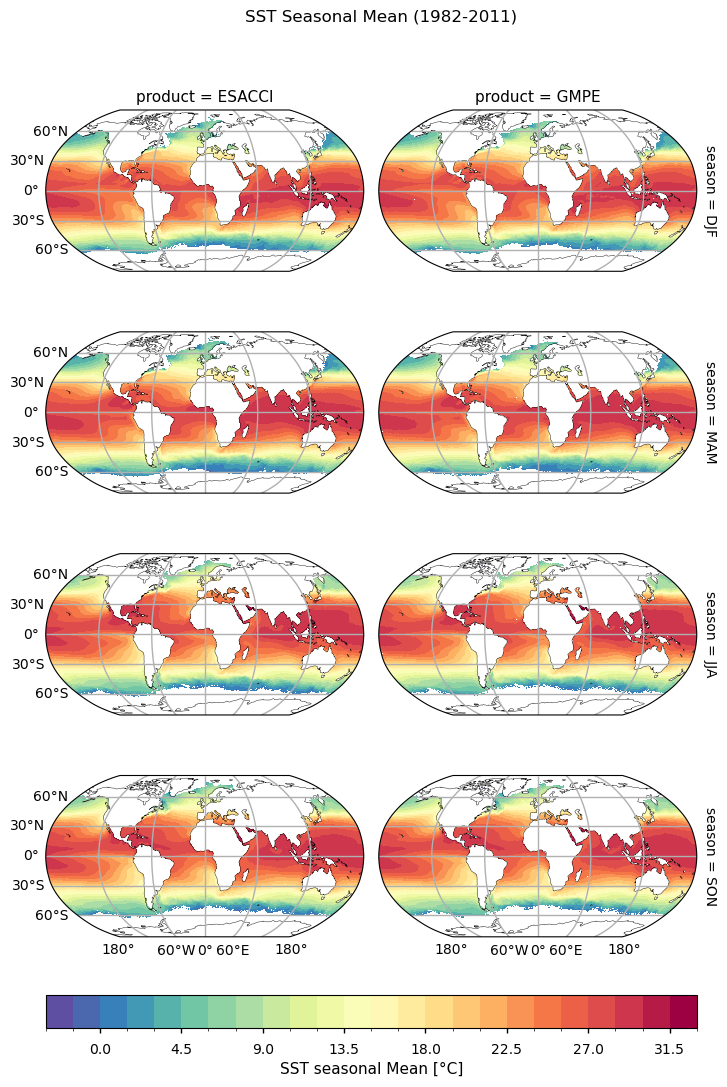

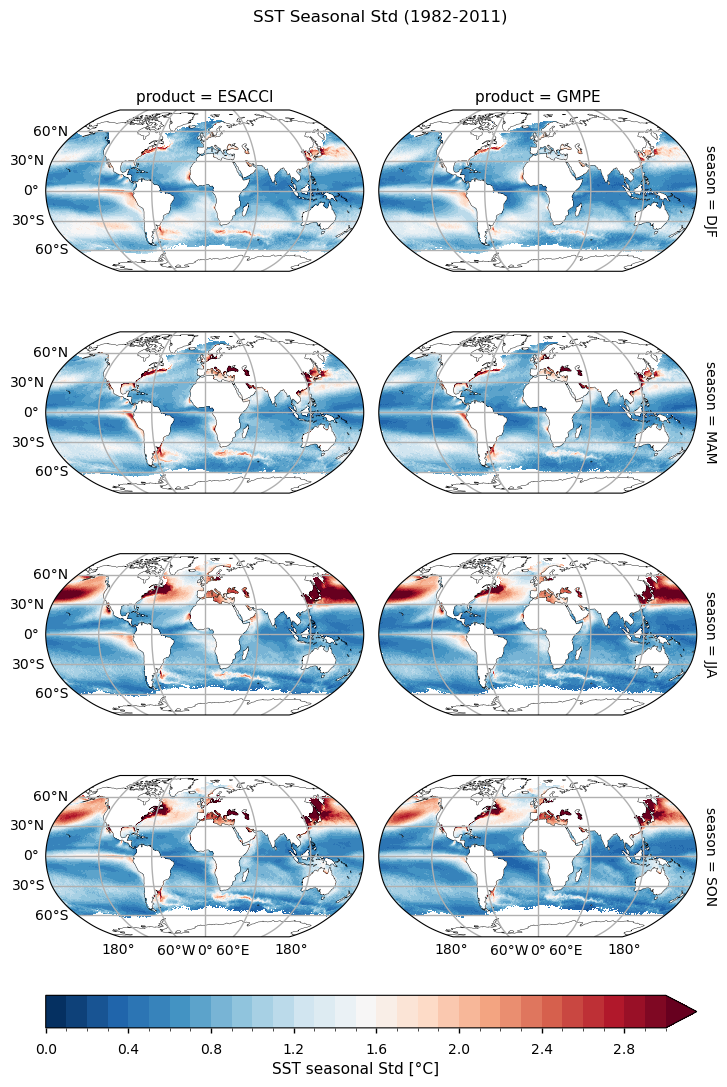

In [11]:
datasets = []
for product, ds in datasets_seasonal.items():
    if product == "ESACCI":
        ds = ds.coarsen(latitude=5, longitude=5).mean()
        ds["latitude"] = ds["latitude"].round(3)
        ds["longitude"] = ds["longitude"].round(3)
    datasets.append(ds.expand_dims(product=[product]))
ds = xr.concat(datasets, "product")

for reduction, da in ds["analysed_sst"].groupby("reduction"):
    title = f"SST Seasonal {reduction.title()} ({year_start}-{year_stop_map})"
    kwargs = {"projection": ccrs.Robinson(), "cbar_kwargs": {'pad': 0.05, 'orientation': 'horizontal', 'label':f"SST seasonal {reduction.title()} [{da.attrs['units']}]"}}

    # Reduction
    plot.projected_map(
        da,
        cmap="Spectral_r" if reduction == "mean" else "RdBu_r",
        center=False,
        levels=31,
        vmin=None if reduction == "mean" else 0.,
        vmax=None if reduction == "mean" else 3.0,
        col="product",
        row="season",
        **kwargs,
    )
    plt.suptitle(title)
    plt.show()


Seasonal SST climatologies show similar patterns among the two datasets, with a warmer (cooler) Northern Hemisphere during boreal summer (winter), as expected; the converse holds true for the Southern Hemisphere. It can be noticed the strong influence of major western boundary currents, such as the Gulf Stream and the Kuroshio in determining seasonal oscillations. Overall, from this pictures the two dataset are found in good agreement.

Right after, seasonal standard deviation maps for each product are shown. For example, the DJF map is expressed by the following formula
 $\sqrt{\frac{1}{N}\sum_{i=1}^{N}\left(SST^i_{DJF} - \langle SST_{DJF}\rangle\right)^2},$ where $N$ is the number of observations (i.e. 30 winter seasons in the present case) and $\langle SST_{DJF} \rangle$ is the average wintertime map.  
Seasonal standard deviation maps are very similar between the two products, revealing that on average the Northern Hemisphere have a much higher variability than the Southern one, with the Gulf Stream and Kuroshio dominating the patterns year round. Also, signs of high variability are noticeable in both dataset in El-Niño Region and around the Agulhas. While the first region is a reflection of a dominant climate mode, the second one arises as a result of strong mixing and turbulence. 

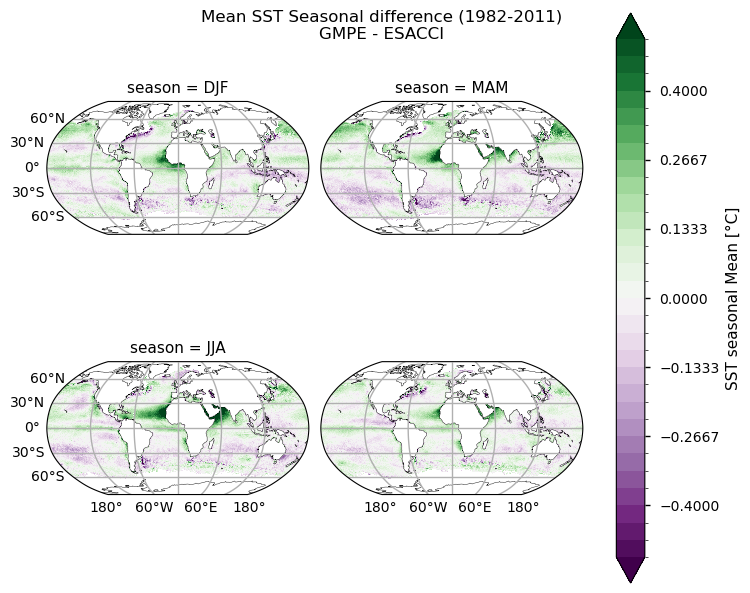

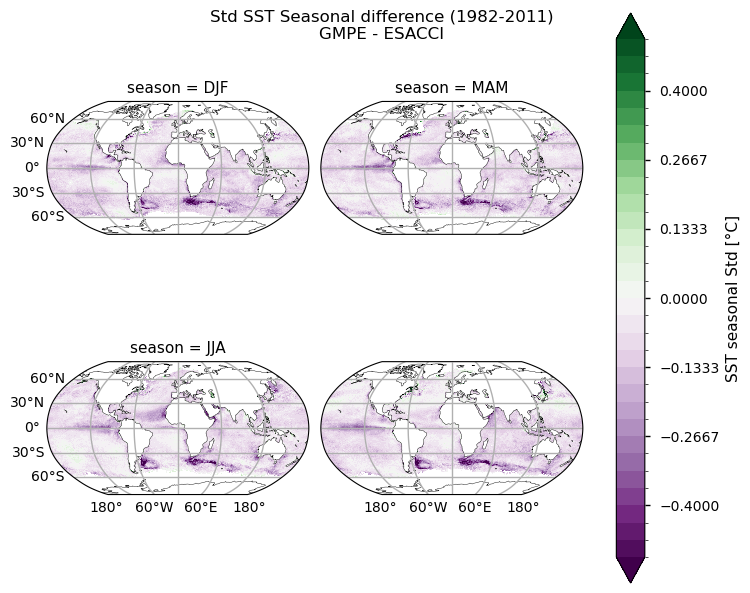

In [12]:
for reduction, da in ds["analysed_sst"].groupby("reduction"):
    title = f"{reduction.title()} SST Seasonal difference ({year_start}-{year_stop_map})"
    kwargs = {"projection": ccrs.Robinson(), "cbar_kwargs": {'label':f"SST seasonal {reduction.title()} [{da.attrs['units']}]"}}

    # Reduction
    plot.projected_map(
        da.diff("product").squeeze().chunk(dict(latitude=-1)).chunk(dict(longitude=-1)).squeeze(),
        cmap="PRGn",
        center=False,
        levels=31,
        vmin=-.5,
        vmax=.5,
        col="season",
        col_wrap=2,
        **kwargs,
    )
    plt.title('')
    plt.suptitle(title + "\n" + " - ".join(da["product"][::-1].values))
    plt.show()

We also plot difference maps to highlight discrepancies in the two datasets. We can clearly notice that major differences are located within the tropical belt, mainly near Africa and in the Northern Indian Ocean. As stated above, these discrepancies can be partly attributed to unresolved dust events in ESA CCI SST. 

#### 4.4 Plot of global monthly mean time series, Eastern Tropical Pacific SST (El Niño 3), and East Central Tropical Pacific SST (El Niño 3.4)

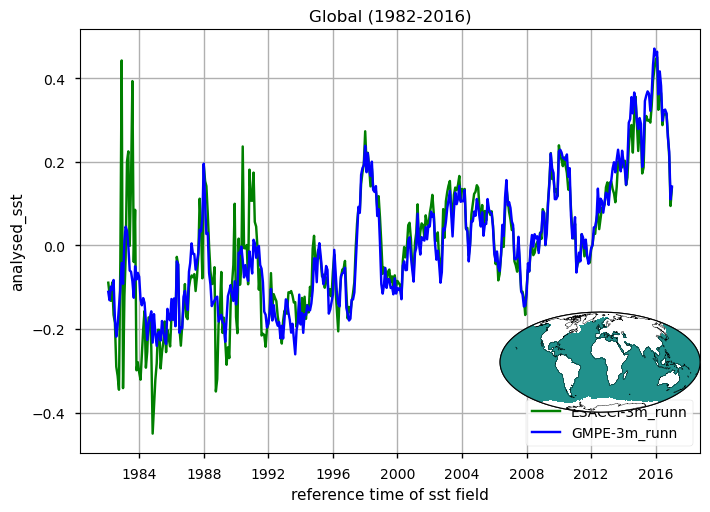

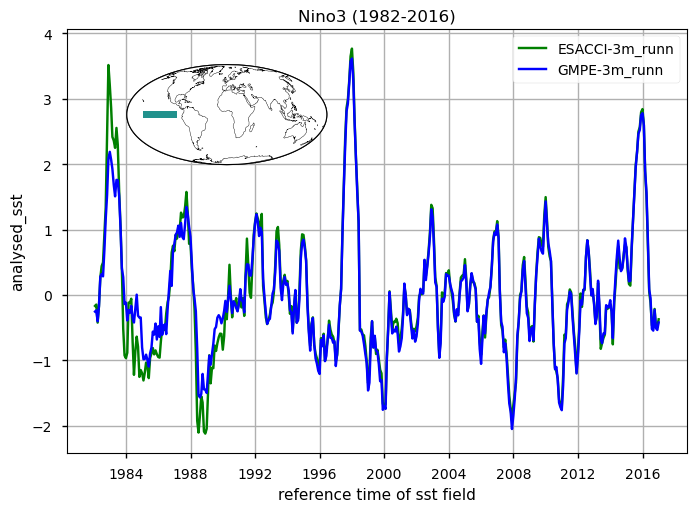

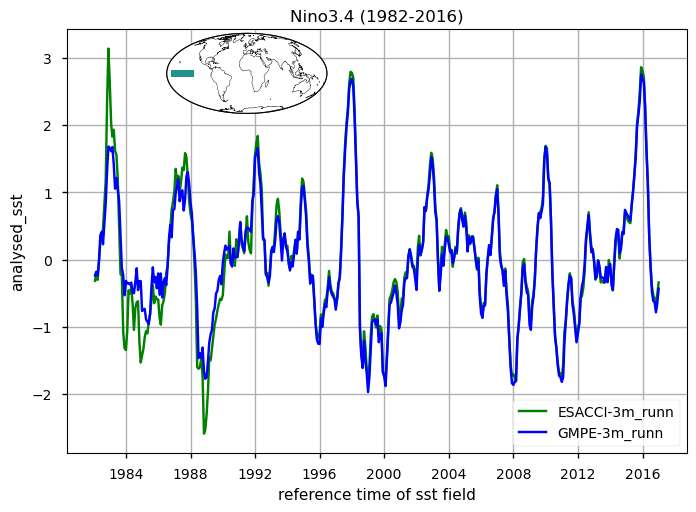

In [13]:
import numpy as np
reg1_latmax, reg1_latmin, reg1_lonmax, reg1_lonmin = 90, -90, 180, -180
reg2_latmax, reg2_latmin, reg2_lonmax, reg2_lonmin = 5, -5, -90, -150
reg3_latmax, reg3_latmin, reg3_lonmax, reg3_lonmin = 5, -5, -120, -170
left1, bottom1, width1, height1 = [0.65, 0.15, 0.25, 0.25]
left2, bottom2, width2, height2 = [0.2, 0.6, 0.25, 0.25]
left3, bottom3, width3, height3 = [0.25, 0.7, 0.2, 0.2]
reg_extremes = [[reg1_latmax, reg1_latmin, reg1_lonmax, reg1_lonmin], [reg2_latmax, reg2_latmin, reg2_lonmax, reg2_lonmin], [reg3_latmax, reg3_latmin, reg3_lonmax, reg3_lonmin]]
locations = [[left1, bottom1, width1, height1],[left2, bottom2, width2, height2], [left3, bottom3, width3, height3]]
i=0
for region, da_region in ds_timeseries["analysed_sst"].groupby("region"):
    reg_latmax, reg_latmin, reg_lonmax, reg_lonmin = reg_extremes[i]
    mute_map = ds['analysed_sst'].isel(season=0).sel(latitude=slice(reg_latmin, reg_latmax), longitude=slice(reg_lonmin, reg_lonmax)).drop('season')
    reg_mask = xr.where(~np.isnan(mute_map), 1, np.nan).isel(product=1, reduction=1)
    left, bottom, width, height = locations[i]
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=["green", "blue"])
    ax.set_xlabel('time [months]')
    ax.set_ylabel('SST Anomaly [°C]')
    for product, da_product in da_region.groupby("product"):
        mean = da_product.sel(reduction="mean").resample(time='ME').mean().rolling(time=3).mean()
        mean.plot(hue="product", ax=ax, label=product+'-3m_runn', add_legend=False)
        ax2 = fig.add_axes([left, bottom, width, height], projection=ccrs.Mollweide())
        ax2.set_global()
        p2 = reg_mask.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False)
        ax2.coastlines()
        ax2.set_title('')
        ax.set_title(f"{region.title()} ({year_start}-{year_stop_timeseries})")
    ax.legend()
    ax.grid()
    plt.show()
    i+=1


The time series illustrating the globally averaged monthly mean SST anomalies from 1982 to 2016 is presented. These anomalies were derived by subtracting the annual cycle from the product’s monthly mean time series, representing the mean of each month over the entire period (1982-2016). This processing aims to minimize the impact of the seasonal component, thereby enhancing the contribution of higher and lower frequency components. Notably, variations at an interannual time scale are prominently displayed. These changes are mostly related to strong signatures of El Niño Southern Oscillation (ENSO) variability, with a particular strong and sharp increase (warming) in SST during e.g. the 1982/3, 1987/88, 1991/92, 1994/95, 1997/8 and 2009/10 El Niño events, and negative (cooling) peaks during the 1983/5, 1988/9, 1995/6 and 2006/7 La Niña events. Differences between the two time series which exceed 0.5 degrees characterize the first decade of the period, before 1990. The large and sharp peak in 1982/3 reveals apparently erroneous SSTs, as also evidenced in the SST CCI Climate Assessment Report (CAR, available at https://climate.esa.int/media/documents/SST_CCI_D5.1_CAR_v1.1-signed.pdf). 
The time series of SST anomalies within the El Niño 3.4 and El Niño 3 regions are also shown (see also [[6]](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) for a definition of El Niño Southern Oscillation indices). These time series are used as indexes to monitor the occurrence and variability of El Niño and la Niña events. The El Niño 3.4 index is defined as the average equatorial SST anomalies across the Pacific in the region 5°S-5°N, 170W°-120W°, while El Niño 3 between 150°W-90°W. Peaks corresponding to El-Niño/La-Niña events are well represented by both GMPE and ESA CCI SST products. See [[6]](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) for reference.
For both the global mean timeseries and El Niño indexes, there are discrepancies in ESA CCI compared to GMPE SST (GMPE is here used as intercomparison benchmark due to its high accuracy, following [[1]](https://doi.org/10.1016/j.rse.2018.12.015), [[7]](https://doi.org/10.1016/j.dsr2.2012.04.013)),  in the period 1982 to 1992. Such discrepancies are highly attenuated from 1992 onwards, suggesting that ESA CCI data should be used with caution in the first decade of the CDR. 



## ℹ️ If you want to know more

### Key resources

SST CCI Climate Assessment Report (CAR): https://climate.esa.int/media/documents/SST_CCI_D5.1_CAR_v1.1-signed.pdf

GHRSST Website: https://www.ghrsst.org/

Additional sources for SST ensemble intercomparison statistics: https://ghrsst-pp.metoffice.gov.uk/ostia-website/gmpe-monitoring.html

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
* python packages: matplotlib, xarray, cartopy, numpy, tqdm
  
### References

[[1]](https://doi.org/10.1016/j.rse.2018.12.015) Fiedler, E. K., McLaren, A., Banzon, V., Brasnett, B., Ishizaki, S., Kennedy, J., ... & Donlon, C. (2019). Intercomparison of long-term sea surface temperature analyses using the GHRSST Multi-Product Ensemble (GMPE) system. Remote sensing of environment, 222, 18-33

[[2]](https://doi.org/10.1038/s41597-019-0236-x) Merchant, C. J., Embury, O., Bulgin, C. E., Block, T., Corlett, G. K., Fiedler, E., ... & Donlon, C. (2019). Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific data, 6(1), 223. https://doi.org/10.1038/s41597-019-0236-x

[[3]](https://doi.org/10.1146/annurev-marine-120408-151453) Deser, C., Alexander, M. A., Xie, S. P., & Phillips, A. S. (2010). Sea surface temperature variability: Patterns and mechanisms. Annual review of marine science, 2, 115-143.

[[4]](https://doi.org/10.1175/JCLI-D-20-0793.1) Yang, C., Leonelli, F. E., Marullo, S., Artale, V., Beggs, H., Nardelli, B. B., ... & Pisano, A. (2021). Sea surface temperature intercomparison in the framework of the Copernicus Climate Change Service (C3S). Journal of Climate, 34(13), 5257-5283

[[5]](https://doi.org/10.1080/1755876X.2016.1273446) Von Schuckmann et al. (2016). The Copernicus Marine Environment Monitoring Service Ocean State Report. Jour. Operational Ocean., vol. 9, 2016, suppl. 2. doi: https://doi.org/10.1080/1755876X.2016.1273446

[[6]](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) Trenberth, Kevin & National Center for Atmospheric Research Staff (Eds). Last modified 21 Jan 2020. "The Climate Data Guide: Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI)." Retrieved from https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni


[[7]](https://doi.org/10.1016/j.dsr2.2012.04.013) Martin, M., Dash, P., Ignatov, A., Banzon, V., Beggs, H., Brasnett, B., ... & Roberts-Jones, J. (2012). Group for High Resolution Sea Surface temperature (GHRSST) analysis fields inter-comparisons. Part 1: A GHRSST multi-product ensemble (GMPE). Deep Sea Research Part II: Topical Studies in Oceanography, 77, 21-30